bella leogay

ho tentato intanto di farlo adattivo per la covarianza di mu

ho creato la funzione "update_proposal_covariance" che piglia in entrata la covarianza al tempo t, media campionaria dei mu in t-1, mu in t e il tempo t e restituisce l'update della covarianza in t+1 e la media campionaria dei mu in t

la funzione la chiamo in runmcmc appena dopo il run one gibbs

le strutture dati per salvarsi covarianze e medie campionarie sono dei numpy array di k componenti, una per cluster

a runonegibbs passo tutto l'array, poi dentro runonegibbs quando chiama i sample uniq valls passo solo la componente del vettore delle covarianze relativo al cluster di cui dobbiamo fare il sample

quindi poi samplo dalla proposal con la nuova cov e torno indietro il nuovo mu per aggiornare la media campionaria

comunque ho fatto un bordello per farlo e sicuramente ci sarà un modo più intelligente, non so nemmeno se ho capito bene la formula nel paper

l'update della covarianza lo inizio dall'iter 10 peerchè nel paper diceva di iniziare dopo un tot e perchè altrimenti con i valori iniziali delle medie tornava una matrice non definita positiva che non ha senso

l'update della media campionaria lo faccio comunque anche nelle prime 10 iter con l'else


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

/Users/leopere/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
sampled_perturbed = np.load('sampled_2D_two_clusters_near.npy')
data = sampled_perturbed[0 : 1000]
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 10
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)
cluster_allocs_recorded = []
uniq_vals_out = []
covs_recorded = []
mus_recorded = []

In [8]:
def run_one_gibbs(data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov):
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            mus[h],covs[h], acc_rate = sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, mus,covs, h,bij,cov_prop_mu[h],cov_prop_cov)
        else:
            mus[h],covs[h], acc_rate = sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu[h],cov_prop_cov)
    
    #print("mus" + str(mus))
    #print("covs" + str(covs))
    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    #print("weights" + str(weights))
    
    cluster_allocs = update_cluster_allocs(data, weights, mus,covs)
    #print("Cluster allocs" + str(cluster_allocs))
    
    #Save the values so that if we stop the kernel we have a visual output 
    global cluster_allocs_recorded
    cluster_allocs_recorded = cluster_allocs

    global mus_recorded
    mus_recorded = mus
    
    global covs_recorded
    covs_recorded = covs
    
    return cluster_allocs, mus,covs, weights, acc_rate

def run_mcmc(data, k , niter=1000, nburn=300, thin=5 ): 
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    
    #Bijector setup
    tfb = tfp.bijectors
    bij = tfb.Chain([
            tfb.TransformDiagonal(tfb.Softplus()),
            tfb.FillTriangular()])

    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    mus = np.array(tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k))
    covs = np.array(tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k))
    

    
    #cov_prop: covariance matrix for the mean sampling
    #nu_prop: precision parameter in the Wishart
    

    ############  NEW ##############
    me=np.expand_dims(np.zeros(2),axis=0)
    mu_mean=np.repeat(me,k,axis=0) 
    
    co=np.expand_dims(0.1 * np.eye(2),axis=0)
    cov_prop_mu =np.repeat(co, k,axis=0)
    #######################################

    cov_prop_cov = 0.02 * np.eye(3)


    #Output values
    allocs_out = []
    mus_out = []
    covs_out = []
    weights_out = []
    acc_rates = []
    
    #Useful value
    data_mean = np.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        
        cluster_allocs, mus,covs, weights, acc_rate = run_one_gibbs(
            data, cluster_allocs, mus,covs, weights, alpha,bij,cov_prop_mu,cov_prop_cov)
        acc_rates.append(acc_rate)
        
        
        ################  NEW ##############
        t=i+1
        mu_old=mus 
        print(i)
        if(i>10):
               cov_prop_mu , mu_mean = update_proposal_covariance(cov_prop_mu,mu_mean,mu_old,t) 
        else:
               mu_mean=(mu_mean*(t-1)+mu_old)/t
        
        #####################################

        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            mus_out.append(mus.copy())
            covs_out.append(covs.copy())
            weights_out.append(weights)
            
        if i % 10 == 0 and i > 11:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            print("Acceptance rate: " + str(np.mean(acc_rates[-10:])))
            
    return allocs_out, mus_out,covs_out, weights_out,acc_rates

In [9]:
def sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, mus,covs, h,bij,cov_prop_mu,cov_prop_cov):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """
    print(cov_prop_mu)
    #Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )
    

    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij)
    jac_term = log_jac_cov - log_jac_cov_old
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(clusdata,mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    draw = tfd.Uniform().sample()
    print(beta)
    # Select the new or old values 
    if(np.log(draw) >= beta):
        return mu_old,cov_old,accept_rate

    else:
        return mu,cov,accept_rate
    
def sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov):
    """
    Perform one step of the Metropolis Hastings to sample a couple (mu,cov) from N*IW*Wasserstein
    """

    print(cov_prop_mu)
    # Starting point of MH
    mu_old = mus[h]
    cov_old = covs[h]
    log_jac_cov_old = abs(bij.forward_log_det_jacobian( bij.inverse(cov_old) ) )


    # Sample the proposal using Bijector and compute jacobian term of transformation
    mu, cov, log_jac_cov = sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov,bij)
    jac_term = log_jac_cov - log_jac_cov_old
    
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term)
    beta = np.minimum(0, beta)
    accept_rate = np.exp(beta)
    
    draw = tfd.Uniform().sample()
    print(beta)
    # Select the new or old values 
    if(np.log(draw) >= beta):
        return np.array(mu_old),np.array(cov_old),accept_rate

    else:
        return np.array(mu),np.array(cov),accept_rate
    

def sample_from_bijector(mu_old, cov_prop_mu, cov_old, cov_prop_cov, bijector):
    """
    Sample new mean and covariance matrix through the bijection
    """

  
    mu = tfd.MultivariateNormalFullCovariance(mu_old, cov_prop_mu).sample()
    
    chol = np.linalg.cholesky(cov_old)
    vec = bijector.inverse(chol)
    vec_sampl = tfd.MultivariateNormalFullCovariance(vec,cov_prop_cov).sample()
    cov_sampl = bijector.forward(vec_sampl)
    cov = np.matmul(cov_sampl , np.transpose(cov_sampl))
    log_jac = abs(bijector.forward_log_det_jacobian(vec_sampl))
    
    return mu,cov,log_jac

def compute_beta_NW_log(clusdata,mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_n
    """
    print(mu)
    mu_0 = np.zeros(2)
    cov_0 = np.eye(2)
    nu_0 = 3
    phi_0 = nu_0*np.eye(2)
    
    # NW distribution terms
    num_0 = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den_0 = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Data distribution terms
    num_1 = np.sum(tfd.MultivariateNormalFullCovariance(mu, cov).log_prob(clusdata))
    den_1 = np.sum(tfd.MultivariateNormalFullCovariance(mu_old, cov_old).log_prob(clusdata))
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        if(j != h):
            mu_j = mus[j]
            cov_j = covs[j]
            sum_ = sum_ + np.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) - np.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))

#     print("num0:")
#     print(num_0)
#     print("den0:")
#     print(den_0)
#     print("num1:")
#     print(num_1)
#     print("den1:")
#     print(den_1)
#     print("sum_")
#     print(sum_)
#     print("mu_old")
#     print(mu_old)
#     print("mu")
#     print(mu)
    return num_0 + num_1  - den_0 - den_1 + sum_ + jac_term

def compute_beta_NW_prior_log(mus,covs, h, mu, cov,mu_old, cov_old,jac_term):
    """
    Compute Metropolis Hastings term, knowing the proposal is symmetric
    The target is the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nus the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_s the Normal Inverse Wishart with parameters mu_n, lam_n, phi_n, nu_"n
    """
    
    mu_0 = np.zeros(2)
    cov_0 = np.eye(2)
    nu_0 = 3
    phi_0 = np.eye(2)/nu_0
    
    # NW distribution terms
    num = evaluate_NW_log(mu, cov, mu_0, cov_0, phi_0, nu_0)
    den = evaluate_NW_log(mu_old, cov_old , mu_0, cov_0, phi_0, nu_0)
    
    # Wasserstein Distance terms
    sum_ = 0
    for j in range(k):
        if(j != h):
            mu_j = mus[j]
            cov_j = covs[j]
            sum_ = sum_ + np.log(compute_Wasserstein(mu , cov , mu_j , cov_j)) - np.log(compute_Wasserstein(mu_old , cov_old , mu_j, cov_j))
#     print("num" + str(num))   
#     print("den" + str(den))   
#     print("jac" + str(jac_term)) 
#     print("mu_old" + str(mu_old))
#     print("mu" + str(mu))
#     print("sum" + str(sum_))
    return num  - den + sum_ + jac_term
  
def evaluate_NW_log(x_mu, x_cov, mu_n, cov_n, phi_n, nu_n):
    """
    Evaluate the likelihood: L[ (x_mu, x_cov) | ( mu_n, cov_n, phi_n, nu_n ) ]
    L = Normal x Inverse Wishart
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, cov_n).log_prob(x_mu)
    
    return f1 + f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case, already taking consideration of g() to bound Wasserstein term
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    # Function g
    if(norm + trace < 15):
        return norm + trace
    else:
        return 15

def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()

def update_cluster_allocs(data, weights, mus, covs):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(mus, covs).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    return tfd.Categorical(probs=probs, validate_args=True).sample()

In [10]:
#######################  NEW ########################
def update_proposal_covariance(cov_prop_old,mu_mean,mu,t): 
    sd=np.power(2.4,2)/d
    eps=0.001
    temp=np.expand_dims(np.zeros(2),axis=0)
    mu_mean_t=np.repeat(temp,k,axis=0) 
    for h in range(k):
     
      
        mu_mean_t[h]=(mu_mean[h]*(t-1)+mu[h])/t
      
        cov_prop_old[h]=((t-1)/t)*cov_prop_old[h]+(sd/t)*(t*np.inner(mu_mean[h],mu_mean[h])
                        -(t+1)*np.inner(mu_mean_t[h],mu_mean_t[h])
                        +np.inner(mu[h],mu[h])+eps*np.eye(2))
    

    return cov_prop_old, mu_mean_t

In [12]:
#RUNNING THE MCMC
start = time.time()
allocs_out, mus_out,covs_out, weights_out,accept_rate_out = run_mcmc(data, k , niter = 200,nburn = 200,thin = 1)
end = time.time()
print("Total time: " + str(end-start))

[[0.1 0. ]
 [0.  0.1]]
[0.15415365 0.73918383]
0.0
[[0.1 0. ]
 [0.  0.1]]
[0.54456352 0.33426385]
-225849.64903835874
[[0.1 0. ]
 [0.  0.1]]
[0.25556681 0.26129169]
-56.71888152802591
[[0.1 0. ]
 [0.  0.1]]
[ 0.32605939 -0.12440397]
-3129.914438485261
[[0.1 0. ]
 [0.  0.1]]
[ 0.0515968  -0.23116106]
0.0
[[0.1 0. ]
 [0.  0.1]]
[0.38474618 0.09922716]
0.0
[[0.1 0. ]
 [0.  0.1]]
[0.05935317 1.14254472]
0.0
[[0.1 0. ]
 [0.  0.1]]
[0.61451962 0.94320461]
0.0
[[0.1 0. ]
 [0.  0.1]]
[0.40310564 0.54839547]
-260.93145304766136
[[0.1 0. ]
 [0.  0.1]]
[0.78869238 0.40536222]
0.0
0
[[0.1 0. ]
 [0.  0.1]]
[-0.03869331  0.63377226]
0.0
[[0.1 0. ]
 [0.  0.1]]
[0.30712318 0.68098061]
-948.145033465981
[[0.1 0. ]
 [0.  0.1]]
[0.2357628 0.4416735]
-140.72101343703295
[[0.1 0. ]
 [0.  0.1]]
[0.15430415 0.65929212]
0.0
[[0.1 0. ]
 [0.  0.1]]
[ 0.20447106 -0.2819238 ]
-10.89575772006898
[[0.1 0. ]
 [0.  0.1]]
[ 0.29839557 -0.23106674]
-125.8984585366561
[[0.1 0. ]
 [0.  0.1]]
[0.28988707 0.27823824]
0.0
[

-5.77760233092469
[[0.1754665  0.09627793]
 [0.09627793 0.1754665 ]]
[-0.10171189  0.7266276 ]
-3.5842962997505547
[[0.33494083 0.25575226]
 [0.25575226 0.33494083]]
0.0
[[0.307327   0.22813843]
 [0.22813843 0.307327  ]]
-1.4442797371530214
[[2.66594904 2.58676047]
 [2.58676047 2.66594904]]
[-2.80305778 -0.88556294]
0.0
[[0.08816057 0.008972  ]
 [0.008972   0.08816057]]
[0.38336486 0.18496237]
0.0
[[0.45189658 0.37270801]
 [0.37270801 0.45189658]]
[1.76191597 2.87090849]
-2.3626709571297435
[[0.13495693 0.05576836]
 [0.05576836 0.13495693]]
[ 1.1304998 -0.8103486]
-4.554534260471252
[[0.54082375 0.46163518]
 [0.46163518 0.54082375]]
0.0
14
[[0.25283818 0.17873684]
 [0.17873684 0.25283818]]
[1.06007177 1.88949987]
0.0
[[0.15303335 0.07893202]
 [0.07893202 0.15303335]]
-36.27340712114168
[[0.23906822 0.16496688]
 [0.16496688 0.23906822]]
[-0.83270559 -0.60502389]
0.0
[[0.64268453 0.5685832 ]
 [0.5685832  0.64268453]]
0.0
[[0.33785894 0.26375761]
 [0.26375761 0.33785894]]
-1.8029270866404

-15.847134438938873
[[1.25537758 1.20798425]
 [1.20798425 1.25537758]]
[-0.5981454  -0.72810537]
-0.1689267397439671
[[7.98108309 7.93368975]
 [7.93368975 7.98108309]]
-5.421405533001162
[[1.71164021 1.66424688]
 [1.66424688 1.71164021]]
-4.481562345042226
[[5.52191679 5.47452345]
 [5.47452345 5.52191679]]
[-5.91072576 -4.13446815]
-1048.5601582964898
[[0.20317026 0.15577692]
 [0.15577692 0.20317026]]
0.0
[[0.6485293  0.60113596]
 [0.60113596 0.6485293 ]]
[1.86112941 2.73503927]
-5.832165160450983
[[0.1492527  0.10185937]
 [0.10185937 0.1492527 ]]
[ 1.27858387 -0.01251218]
0.0
[[1.74587832 1.69848499]
 [1.69848499 1.74587832]]
0.0
24
[[2.6188293 2.5732165]
 [2.5732165 2.6188293]]
[3.36544846 3.93832747]
-149.63220999020362
[[0.12660579 0.08099299]
 [0.08099299 0.12660579]]
-18.783085781736986
[[1.27411351 1.22850071]
 [1.22850071 1.27411351]]
[-1.6490081  -1.65164467]
-8.981683628538406
[[7.6691367 7.6235239]
 [7.6235239 7.6691367]]
-4.8575683934618645
[[1.82411138 1.77849858]
 [1.7784

-10.063130386930052
[[1.20237524 1.16807406]
 [1.16807406 1.20237524]]
[0.07782097 0.3919176 ]
-0.4715788193438075
[[5.70122471 5.66692354]
 [5.66692354 5.70122471]]
[-0.40349201 -0.3551339 ]
-2.834597467398897
[[1.66327964 1.62897846]
 [1.62897846 1.66327964]]
-5.166135684004355
[[4.76485834 4.73055716]
 [4.73055716 4.76485834]]
[0.63147543 2.20432486]
-2397.286914165
[[1.58154272 1.54724155]
 [1.54724155 1.58154272]]
-0.7585656145972679
[[0.59829277 0.5639916 ]
 [0.5639916  0.59829277]]
-0.3666252827357752
[[0.35142098 0.31711981]
 [0.31711981 0.35142098]]
[ 0.95003073 -0.59768386]
-24.27285585992104
[[3.24708794 3.21278676]
 [3.21278676 3.24708794]]
-0.5520274162451406
34
[[3.39415506 3.36075163]
 [3.36075163 3.39415506]]
[1.6055406 2.4593084]
-57.127795025917024
[[0.46737329 0.43396986]
 [0.43396986 0.46737329]]
-8.070993013709263
[[1.19054767 1.15714424]
 [1.15714424 1.19054767]]
[-1.66431093 -1.36681506]
-5.26265829702219
[[5.54394287 5.51053944]
 [5.51053944 5.54394287]]
-0.2016

-44.54944004209975
[[2.57308663 2.54592663]
 [2.54592663 2.57308663]]
-0.7430821304048469
[[1.35177717 1.32461717]
 [1.32461717 1.35177717]]
0.0
[[0.37347959 0.34631959]
 [0.34631959 0.37347959]]
[ 0.57610762 -0.45540331]
-19.546329506783064
[[4.05234146 4.02518146]
 [4.02518146 4.05234146]]
-12.589883897136357
44
[[3.28556606 3.25894562]
 [3.25894562 3.28556606]]
[2.35927016 2.73737631]
-6.479278736814099
[[0.8701197  0.84349925]
 [0.84349925 0.8701197 ]]
[-2.34112589 -3.72630868]
-308.2470606786554
[[1.08032042 1.05369997]
 [1.05369997 1.08032042]]
[-0.83704338 -0.33878228]
-3.4977632278640853
[[6.15341085 6.1267904 ]
 [6.1267904  6.15341085]]
-10.94715736498267
[[1.54561336 1.51899292]
 [1.51899292 1.54561336]]
[-0.65192001 -0.36655947]
-34.84002024294551
[[4.16452759 4.13790715]
 [4.13790715 4.16452759]]
[-3.27776585 -1.86898603]
0.0
[[2.63410925 2.6074888 ]
 [2.6074888  2.63410925]]
-1.9043968678825527
[[1.82716421 1.80054377]
 [1.80054377 1.82716421]]
0.0
[[0.37266725 0.34604681]

-983.7473912244765
[[2.62459282 2.60192912]
 [2.60192912 2.62459282]]
[-2.08949374 -3.33790011]
-76.54994131575256
[[3.83827058 3.81560688]
 [3.81560688 3.83827058]]
-11.093706229175885
[[0.34638944 0.32372574]
 [0.32372574 0.34638944]]
[-0.50894175 -1.50850696]
-107.96211676938891
[[3.94033191 3.91766821]
 [3.91766821 3.94033191]]
-3.170936981816046
54
[[3.02061557 2.99831157]
 [2.99831157 3.02061557]]
[2.62171176 3.36891591]
-44.8731951829967
[[1.4285312 1.4062272]
 [1.4062272 1.4285312]]
[ 0.18495064 -1.47429388]
-11.507894741153379
[[1.67932168 1.65701768]
 [1.65701768 1.67932168]]
[-0.76000741 -0.36156235]
-2.7585255395433
[[5.57249198 5.55018798]
 [5.55018798 5.57249198]]
-1.7804840644290514
[[1.55608435 1.53378035]
 [1.53378035 1.55608435]]
-3.7280848664933237
[[4.79913368 4.77682968]
 [4.77682968 4.79913368]]
[-4.58865391 -3.58711587]
-239.94060615786992
[[2.59162846 2.56932446]
 [2.56932446 2.59162846]]
-0.5662328505497889
[[3.93442907 3.91212507]
 [3.91212507 3.93442907]]
0.0

-43.617642472540865
[[1.71913844 1.69956594]
 [1.69956594 1.71913844]]
-5.963975964356214
[[5.08072302 5.06115052]
 [5.06115052 5.08072302]]
[-3.09517608 -2.35141869]
0.0
[[2.41014146 2.39056896]
 [2.39056896 2.41014146]]
-0.7512749468775459
[[4.48329393 4.46372143]
 [4.46372143 4.48329393]]
-10.02784834537692
[[0.32149459 0.30192209]
 [0.30192209 0.32149459]]
[ 0.11406685 -1.32317727]
-6.659631537501712
[[3.90771348 3.88814098]
 [3.88814098 3.90771348]]
-1.0154340760573843
64
[[2.74925736 2.72994166]
 [2.72994166 2.74925736]]
[5.35208161 5.79417248]
-1177.7154453138837
[[1.32289629 1.3035806 ]
 [1.3035806  1.32289629]]
[ 0.23696368 -1.24419894]
-5.5617268527312165
[[3.13372433 3.11440864]
 [3.11440864 3.13372433]]
[-1.17907964 -0.29183238]
-3.503274023111065
[[5.48539904 5.46608335]
 [5.46608335 5.48539904]]
-0.9820202543397794
[[1.75484506 1.73552937]
 [1.73552937 1.75484506]]
-3.2085951586681953
[[5.08511711 5.06580141]
 [5.06580141 5.08511711]]
[0.27701063 1.1904944 ]
-928.55273451

-0.6369134268997585
[[5.97963213 5.96231538]
 [5.96231538 5.97963213]]
-2.6495773894815926
[[0.30500354 0.28768678]
 [0.28768678 0.30500354]]
[ 0.67264338 -0.18941489]
-8.768209349627817
[[3.99095839 3.97364164]
 [3.97364164 3.99095839]]
-0.3604334590423184
74
[[2.50499353 2.48786927]
 [2.48786927 2.50499353]]
[3.93174573 4.6928887 ]
-451.69474204885734
[[1.26202012 1.24489585]
 [1.24489585 1.26202012]]
-3.7798810044560494
[[3.21059399 3.19346972]
 [3.19346972 3.21059399]]
-0.4349330160329199
[[5.55212752 5.53500326]
 [5.53500326 5.55212752]]
-13.168221539317033
[[1.97954871 1.96242444]
 [1.96242444 1.97954871]]
-3.5736015747626464
[[5.01625991 4.99913564]
 [4.99913564 5.01625991]]
[0.80565714 1.24347913]
-1178.3994211960166
[[2.14449653 2.12737226]
 [2.12737226 2.14449653]]
-0.9748085540127533
[[6.25620052 6.23907625]
 [6.23907625 6.25620052]]
0.0
[[0.301466   0.28434174]
 [0.28434174 0.301466  ]]
[ 0.28536678 -1.09815571]
-23.273108356666995
[[4.03539253 4.01826826]
 [4.01826826 4.03

-5.311625652304368
[[3.19934723 3.18389876]
 [3.18389876 3.19934723]]
[-1.25993668 -0.54606956]
-0.25446535058227315
[[5.30301369 5.28756522]
 [5.28756522 5.30301369]]
0.0
[[2.05512028 2.03967181]
 [2.03967181 2.05512028]]
-3.1494358620686844
[[4.83565067 4.8202022 ]
 [4.8202022  4.83565067]]
[-1.30620152 -0.60388165]
-225.61866873236025
[[2.16816876 2.15272029]
 [2.15272029 2.16816876]]
-4.164965193325344
[[6.06497525 6.04952678]
 [6.04952678 6.06497525]]
[0.01437806 2.24398182]
-12.121858259937333
[[0.27727797 0.2618295 ]
 [0.2618295  0.27727797]]
[ 0.53998936 -0.53048496]
-3.620262611081502
[[4.79979773 4.78434926]
 [4.78434926 4.79979773]]
-3.695004481641874
85
[[2.27296971 2.25766739]
 [2.25766739 2.27296971]]
[3.4460031  4.30276073]
-286.59380194497186
[[1.38944704 1.37414471]
 [1.37414471 1.38944704]]
-2.454647912035254
[[3.27905294 3.26375062]
 [3.26375062 3.27905294]]
[-4.52974893 -3.59599327]
-20.53406367214607
[[5.2895173  5.27421497]
 [5.27421497 5.2895173 ]]
0.0
[[2.057770

-2.6791629433117543
[[4.40267887 4.3885534 ]
 [4.3885534  4.40267887]]
-8.17484883383886
[[5.6181958  5.60407033]
 [5.60407033 5.6181958 ]]
0.0
[[1.94620798 1.93208251]
 [1.93208251 1.94620798]]
-1.8123886805635665
[[4.61512817 4.6010027 ]
 [4.6010027  4.61512817]]
[-2.61654826 -1.8063654 ]
-8.70940635064859
[[2.1299978  2.11587233]
 [2.11587233 2.1299978 ]]
-1.2558737992960216
[[5.93530589 5.92118041]
 [5.92118041 5.93530589]]
[1.99679195 3.58942915]
-64.24027111368078
[[0.28948658 0.27536111]
 [0.27536111 0.28948658]]
[2.1565798  0.84546627]
-34.75376514034876
[[4.69494372 4.68081825]
 [4.68081825 4.69494372]]
0.0
95
[[2.09231056 2.07830223]
 [2.07830223 2.09231056]]
[2.11005811 2.79227984]
-10.666579601407317
[[1.45723743 1.44322909]
 [1.44322909 1.45723743]]
-2.0856656833725262
[[4.499042   4.48503367]
 [4.48503367 4.499042  ]]
-21.341850118920977
[[5.59049743 5.5764891 ]
 [5.5764891  5.59049743]]
-2.0686117173409997
[[1.92816174 1.91415341]
 [1.91415341 1.92816174]]
-2.46366522115

-47.62950632006232
[[1.77947519 1.76642071]
 [1.76642071 1.77947519]]
-4.085379460741968
[[4.38644343 4.37338896]
 [4.37338896 4.38644343]]
[-7.86822234 -7.22653386]
-2035.9260267155246
[[2.32160611 2.30855164]
 [2.30855164 2.32160611]]
-0.6721838448551019
[[5.73279718 5.71974271]
 [5.71974271 5.73279718]]
[2.79514014 4.60732044]
-77.26586341900355
[[0.32331762 0.31026314]
 [0.31026314 0.32331762]]
[ 0.24788665 -0.62434443]
0.0
[[4.32088952 4.30783504]
 [4.30783504 4.32088952]]
0.0
105
[[1.93281697 1.91985848]
 [1.91985848 1.93281697]]
[1.62311456 2.22703762]
-36.65215857493788
[[1.41483676 1.40187827]
 [1.40187827 1.41483676]]
-1.517559053888685
[[5.53857001 5.52561152]
 [5.52561152 5.53857001]]
-11.568415187852185
[[5.35619317 5.34323467]
 [5.34323467 5.35619317]]
[ 1.13162206 -0.69914948]
-19.591049159478015
[[1.76434172 1.75138323]
 [1.75138323 1.76434172]]
-3.0195303821078427
[[4.3637618  4.35080331]
 [4.35080331 4.3637618 ]]
[-6.67095718 -6.12754185]
-1145.1473232015044
[[2.33255

-3.6619677322101856
[[5.56536303 5.5531933 ]
 [5.5531933  5.56536303]]
-16.08472032977853
[[5.19836031 5.18619057]
 [5.18619057 5.19836031]]
0.0
[[1.63879988 1.62663014]
 [1.62663014 1.63879988]]
-2.511319387518483
[[4.16378364 4.1516139 ]
 [4.1516139  4.16378364]]
[-1.61282351 -0.68742752]
-118.50839180064749
[[2.57889198 2.56672224]
 [2.56672224 2.57889198]]
[1.48976903 0.13405583]
-5.0360044553489285
[[5.43950009 5.42733035]
 [5.42733035 5.43950009]]
[3.15939893 4.82914529]
-150.97534118594552
[[0.48088884 0.4687191 ]
 [0.4687191  0.48088884]]
[ 0.44678863 -0.14838956]
-10.915273434943732
[[4.35923963 4.34706989]
 [4.34706989 4.35923963]]
0.0
115
[[1.79301042 1.78092076]
 [1.78092076 1.79301042]]
[2.88070884 3.67406536]
-67.85314775224879
[[1.41838976 1.40630011]
 [1.40630011 1.41838976]]
-11.01208472787666
[[5.55963665 5.54754699]
 [5.54754699 5.55963665]]
0.0
[[5.16073096 5.14864131]
 [5.14864131 5.16073096]]
-2.0606410289325128
[[1.62593533 1.61384568]
 [1.61384568 1.62593533]]
-

-2.4078571612555297
[[3.90719639 3.89576983]
 [3.89576983 3.90719639]]
[-3.63491549 -3.18152875]
-50.45852032614668
[[2.8144581  2.80303154]
 [2.80303154 2.8144581 ]]
-6.041588741888238
[[5.1757259  5.16429934]
 [5.16429934 5.1757259 ]]
[-0.77677767  0.78543293]
-290.9925002213374
[[0.56615695 0.55473039]
 [0.55473039 0.56615695]]
[-0.00448713 -1.28119752]
-15.436145618843693
[[4.3381973  4.32677074]
 [4.32677074 4.3381973 ]]
-3.0617497264579563
125
[[1.68819499 1.67683625]
 [1.67683625 1.68819499]]
[2.4879666  3.15312673]
0.0
[[1.73940256 1.72804383]
 [1.72804383 1.73940256]]
-2.510322431254818
[[5.37020709 5.35884836]
 [5.35884836 5.37020709]]
-1.5398003073832687
[[5.32471261 5.31335388]
 [5.31335388 5.32471261]]
[-0.74875517 -2.34907475]
0.0
[[1.55771591 1.54635718]
 [1.54635718 1.55771591]]
-3.2722560606965603
[[3.88197918 3.87062045]
 [3.87062045 3.88197918]]
[-1.31557107 -0.61816349]
-184.15231235414365
[[2.87207796 2.86071923]
 [2.86071923 2.87207796]]
-4.026865510196025
[[5.152

-16.591587970171332
[[3.0537473  3.04295381]
 [3.04295381 3.0537473 ]]
-3.1421566757226675
[[4.95135115 4.94055767]
 [4.94055767 4.95135115]]
[0.06271651 1.57923984]
-148.18088810128066
[[0.6460498  0.63525632]
 [0.63525632 0.6460498 ]]
[-0.05307766 -1.01156331]
-4.067462700572215
[[4.45766412 4.44687063]
 [4.44687063 4.45766412]]
0.0
135
[[1.67877983 1.66804454]
 [1.66804454 1.67877983]]
[3.61641558 4.27404952]
-213.9818850600938
[[1.89935298 1.88861769]
 [1.88861769 1.89935298]]
-1.757468594414752
[[5.44509432 5.43435902]
 [5.43435902 5.44509432]]
-9.549388566138854
[[5.98346929 5.97273399]
 [5.97273399 5.98346929]]
-7.184945996860828
[[2.50851657 2.49778128]
 [2.49778128 2.50851657]]
-3.1379311668794774
[[3.64584602 3.63511072]
 [3.63511072 3.64584602]]
[-6.52351985 -6.04181806]
-742.3966257273196
[[3.06259616 3.05186087]
 [3.05186087 3.06259616]]
-2.186396890006856
[[4.92944391 4.91870862]
 [4.91870862 4.92944391]]
[2.8739655  4.40020221]
-420.10719295113825
[[0.66579426 0.65505896

-0.8321474349013096
145
[[1.65593618 1.64573892]
 [1.64573892 1.65593618]]
[3.99738566 4.55506822]
-438.1289290677481
[[1.85918167 1.84898441]
 [1.84898441 1.85918167]]
-0.9872079658383939
[[5.22183924 5.21164198]
 [5.21164198 5.22183924]]
0.0
[[6.45619413 6.44599687]
 [6.44599687 6.45619413]]
-0.21985157980672076
[[2.86805533 2.85785807]
 [2.85785807 2.86805533]]
-1.5557510209250442
[[3.44123977 3.43104251]
 [3.43104251 3.44123977]]
[-3.80725503 -3.12580378]
-51.694277578552864
[[3.07892967 3.06873241]
 [3.06873241 3.07892967]]
-0.8681701902363619
[[4.71664422 4.70644696]
 [4.70644696 4.71664422]]
[1.25615649 2.77134451]
-15.67223599159482
[[0.7043434  0.69414614]
 [0.69414614 0.7043434 ]]
[-0.56370074 -1.57949929]
-26.641711612184633
[[4.35762147 4.34742421]
 [4.34742421 4.35762147]]
0.0
146
[[1.65313444 1.64298696]
 [1.64298696 1.65313444]]
[1.62260889 2.1973607 ]
-106.49976401045676
[[1.86367888 1.8535314 ]
 [1.8535314  1.86367888]]
-1.2276838635138816
[[5.20246144 5.19231396]
 [5.

-0.5542477424742995
155
[[1.62491345 1.61518524]
 [1.61518524 1.62491345]]
[2.84722728 3.41921731]
-27.452024054357263
[[1.87981307 1.87008487]
 [1.87008487 1.87981307]]
-2.3747447020679107
[[5.17391705 5.16418884]
 [5.16418884 5.17391705]]
0.0
[[6.34657997 6.33685176]
 [6.33685176 6.34657997]]
0.0
[[3.2662925 3.2565643]
 [3.2565643 3.2662925]]
[-2.66654727 -1.44475156]
-13.286954302748086
[[3.28148011 3.2717519 ]
 [3.2717519  3.28148011]]
[0.74626948 1.4301776 ]
-957.2000515419326
[[3.00589782 2.99616961]
 [2.99616961 3.00589782]]
-0.027466829621641597
[[4.51607348 4.50634528]
 [4.50634528 4.51607348]]
[-0.53895027  0.95718997]
-261.02215979511965
[[0.68452994 0.67480174]
 [0.67480174 0.68452994]]
[ 1.2172586  -0.31740287]
-18.17948722820849
[[4.34197277 4.33224457]
 [4.33224457 4.34197277]]
-3.6916262219700435
156
[[1.62150324 1.61181865]
 [1.61181865 1.62150324]]
[0.4122227  1.11362128]
-720.0368689054782
[[1.89509503 1.88541045]
 [1.88541045 1.89509503]]
-0.09498325378151384
[[5.14

-3.6175917483227122
165
[[1.58908835 1.57977269]
 [1.57977269 1.58908835]]
[2.96686431 3.4302846 ]
-44.50047461313275
[[1.83558716 1.8262715 ]
 [1.8262715  1.83558716]]
-0.9298600664353005
[[5.02038242 5.01106676]
 [5.01106676 5.02038242]]
-1.4349101327393692
[[6.11536589 6.10605023]
 [6.10605023 6.11536589]]
-4.923100630288084
[[3.80122056 3.7919049 ]
 [3.7919049  3.80122056]]
-5.303394280032757
[[3.09446452 3.08514886]
 [3.08514886 3.09446452]]
[-3.29359237 -2.79246681]
-18.33573469840484
[[3.01570706 3.0063914 ]
 [3.0063914  3.01570706]]
-11.170597445157087
[[4.32809391 4.31877824]
 [4.31877824 4.32809391]]
[-1.46340549  0.35418551]
-814.2693232065873
[[0.66423878 0.65492312]
 [0.65492312 0.66423878]]
[1.52943251 0.20676989]
-18.366340593322025
[[4.40791731 4.39860164]
 [4.39860164 4.40791731]]
-0.2696629222412068
166
[[1.58533401 1.57605689]
 [1.57605689 1.58533401]]
[1.78565678 2.61218348]
-70.26357195316254
[[1.82764777 1.81837064]
 [1.81837064 1.82764777]]
-1.3919038012732063
[[

-319.54130623902626
[[2.02873323 2.01978323]
 [2.01978323 2.02873323]]
-0.5731219312823257
[[4.96036901 4.95141901]
 [4.95141901 4.96036901]]
-7.583948670255537
[[5.99176027 5.98281027]
 [5.98281027 5.99176027]]
-2.176504737496582
[[3.8074405 3.7984905]
 [3.7984905 3.8074405]]
-3.210358522080836
[[2.92756921 2.91861921]
 [2.91861921 2.92756921]]
[-5.12159761 -4.54576579]
-382.64409940482705
[[3.07610016 3.06715016]
 [3.06715016 3.07610016]]
-15.327927161765949
[[4.16973961 4.16078961]
 [4.16078961 4.16973961]]
[0.69779333 2.51112747]
-14.45660593265228
[[0.6440145 0.6350645]
 [0.6350645 0.6440145]]
[-0.57413093 -1.37517476]
-39.62763316323135
[[4.56768748 4.55873748]
 [4.55873748 4.56768748]]
-2.363731534760478
176
[[1.553195   1.54427929]
 [1.54427929 1.553195  ]]
[2.60768433 3.31552142]
-2.2907593573098937
[[2.02033426 2.01141855]
 [2.01141855 2.02033426]]
-4.8602342135448335
[[4.94066523 4.93174952]
 [4.93174952 4.94066523]]
-6.750190346626431
[[5.99161714 5.98270143]
 [5.98270143 5

-501.08477930829815
[[3.04300369 3.03438003]
 [3.03438003 3.04300369]]
-2.1850083609741917
[[4.04207886 4.0334552 ]
 [4.0334552  4.04207886]]
[1.928613   3.69229225]
-109.81299234972464
[[0.62356945 0.61494579]
 [0.61494579 0.62356945]]
[ 0.30040931 -1.04608913]
-1.7148376070891267
[[4.72658057 4.71795692]
 [4.71795692 4.72658057]]
0.0
186
[[1.52444847 1.51585553]
 [1.51585553 1.52444847]]
[1.02954167 1.61887585]
-439.34279024420533
[[1.9505931  1.94200016]
 [1.94200016 1.9505931 ]]
-0.9127208989367288
[[5.00095749 4.99236455]
 [4.99236455 5.00095749]]
-26.582255561504518
[[6.00034426 5.99175131]
 [5.99175131 6.00034426]]
-2.6041187820391762
[[3.96785343 3.95926048]
 [3.95926048 3.96785343]]
-1.021705956396334
[[2.76357595 2.75498301]
 [2.75498301 2.76357595]]
[-3.40525607 -2.48556736]
-25.636364959908235
[[3.0330471  3.02445416]
 [3.02445416 3.0330471 ]]
-2.1148368845075867
[[4.02949681 4.02090387]
 [4.02090387 4.02949681]]
[-0.99761794  0.74949574]
-521.698720487103
[[0.62150134 0.61

[-0.37388588 -1.7839739 ]
-14.94723900749996
[[4.88616847 4.87783786]
 [4.87783786 4.88616847]]
[-1.80400478 -1.05434977]
-1.1948552139695163
196
[[1.49337297 1.48507003]
 [1.48507003 1.49337297]]
[2.70858667 3.29855976]
0.0
[[1.92318968 1.91488674]
 [1.91488674 1.92318968]]
-2.9631357110523275
[[5.13443765 5.12613471]
 [5.12613471 5.13443765]]
-0.6333027785628265
[[5.88051204 5.87220909]
 [5.87220909 5.88051204]]
-1.8909353189745695
[[3.89358527 3.88528233]
 [3.88528233 3.89358527]]
-8.799296865779382
[[2.62963899 2.62133604]
 [2.62133604 2.62963899]]
[-0.72817187  0.15725104]
-401.0051592423277
[[3.04650873 3.03820579]
 [3.03820579 3.04650873]]
0.0
[[3.9058971  3.89759416]
 [3.89759416 3.9058971 ]]
[2.41715553 4.09193919]
-228.86386037829996
[[0.65576047 0.64745752]
 [0.64745752 0.65576047]]
[ 0.42759756 -1.05925188]
-4.960062009409679
[[4.87578397 4.86748103]
 [4.86748103 4.87578397]]
0.0
197
[[1.49378092 1.48550536]
 [1.48550536 1.49378092]]
[3.36139847 4.13185528]
-174.87643616306

# Traceplots

8    321
0    306
5    248
7    125
dtype: int64


<BarContainer object of 4 artists>

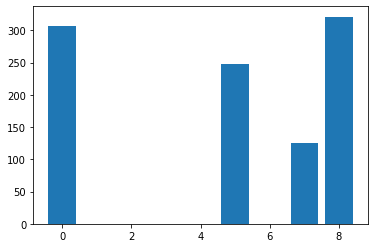

In [13]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(cluster_allocs_recorded).value_counts())
x, y = np.unique(cluster_allocs_recorded, return_counts=True)
plt.bar(x, y)

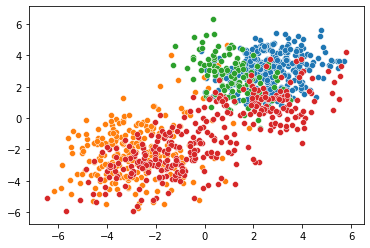

In [14]:
#scatterplot of clusters from last recorded iteration
for h in range(k):
    currd = data[cluster_allocs_recorded == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

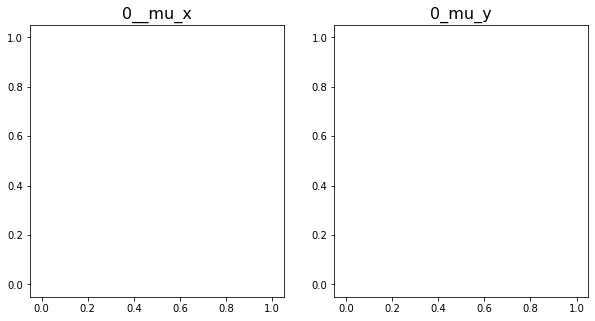

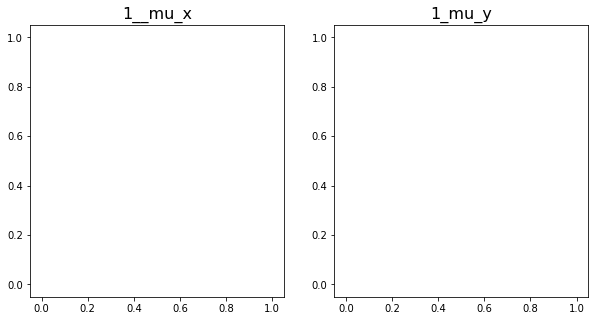

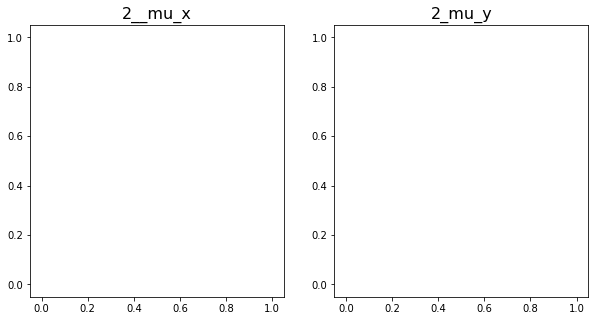

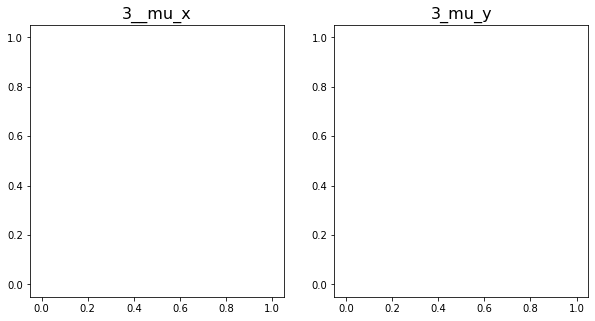

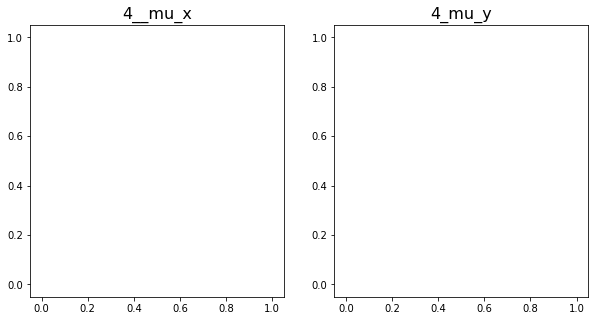

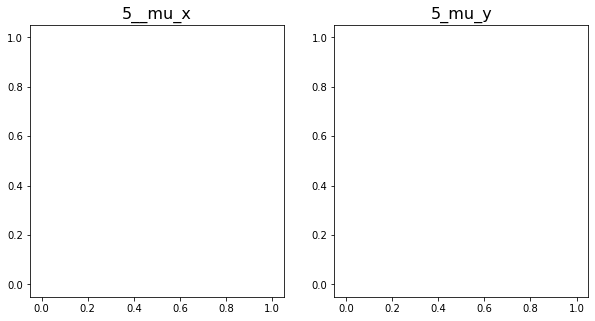

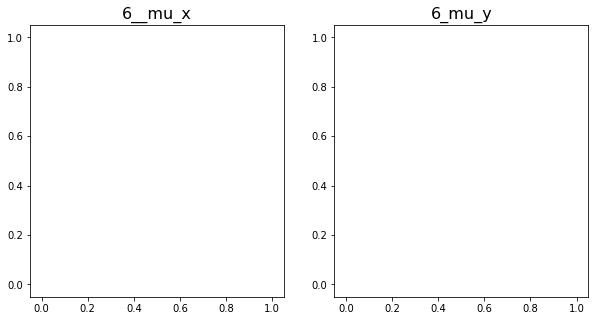

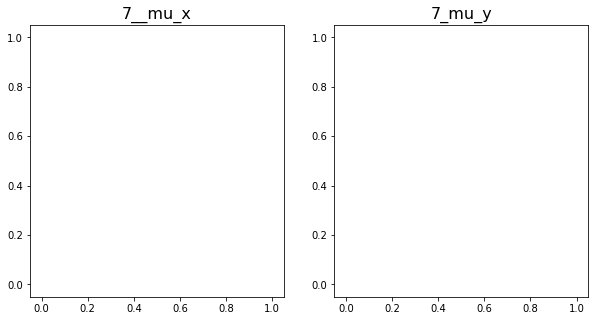

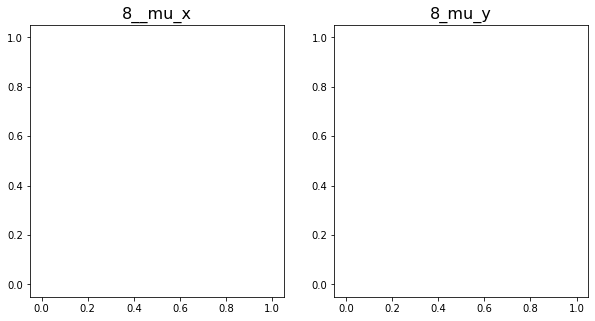

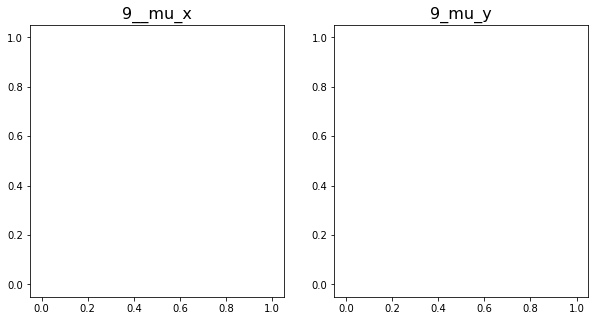

In [15]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [mu[i][0] for mu in mus_out]
    second_comp = [mu[i][1] for mu in mus_out]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__mu_x", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_mu_y", fontsize=16)

    plt.show()

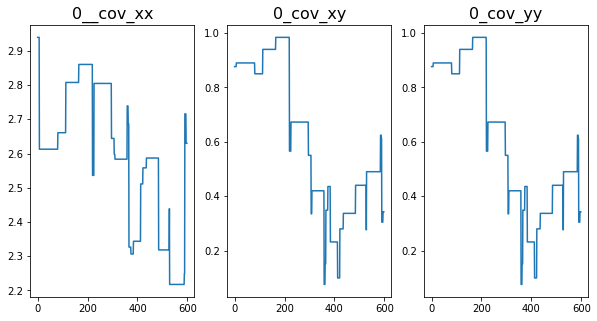

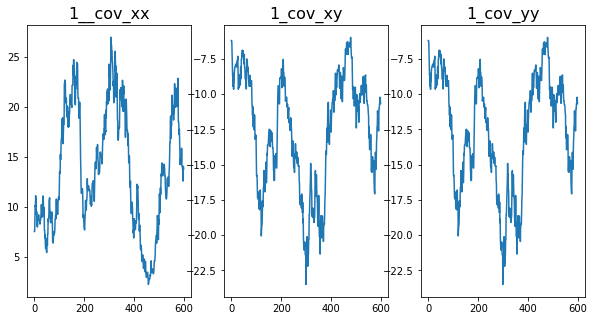

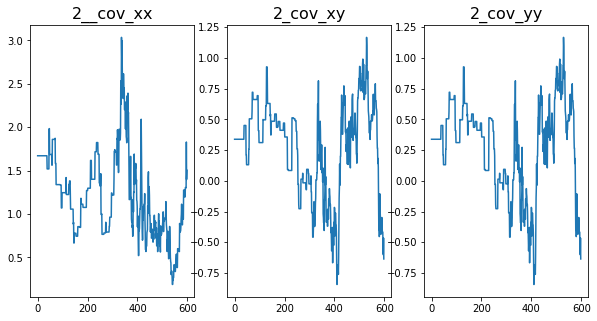

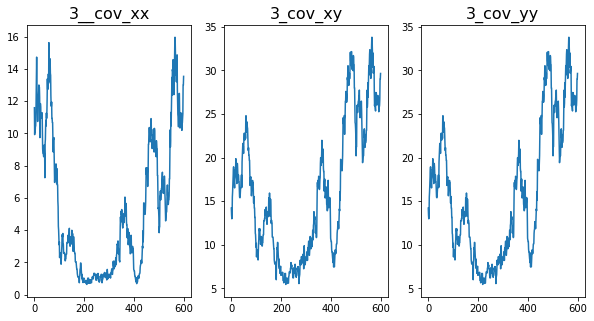

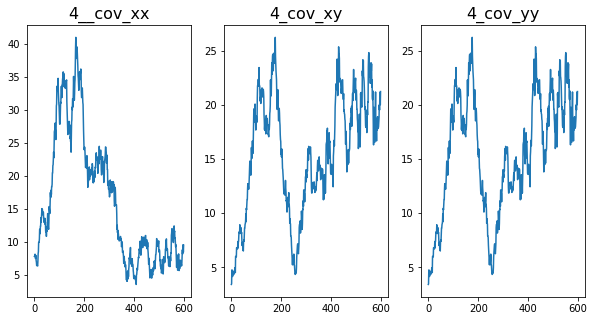

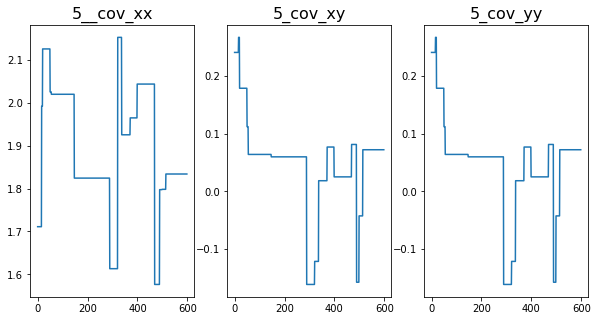

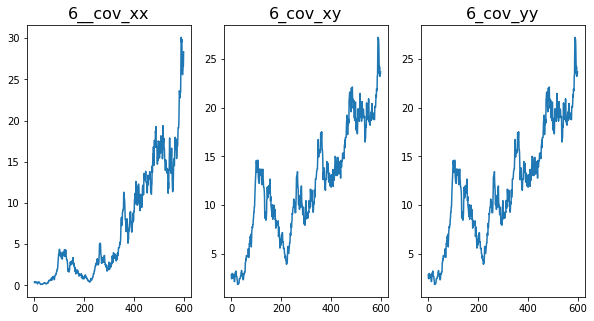

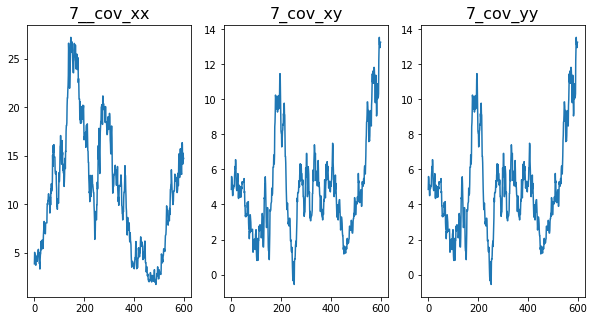

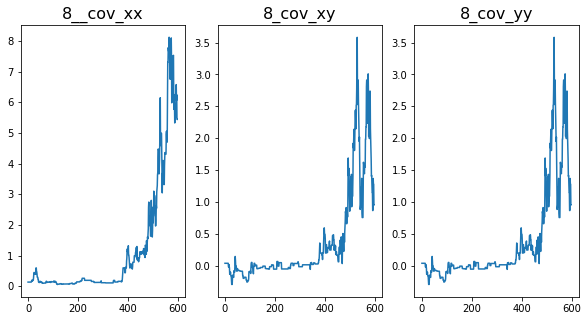

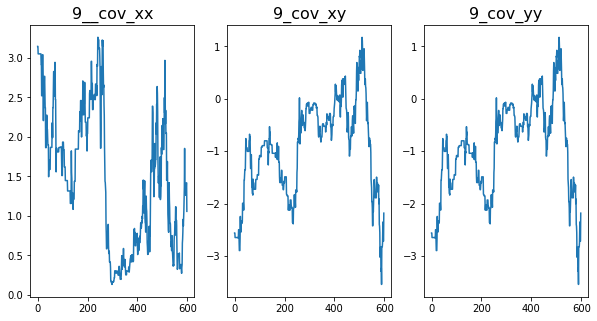

In [ ]:
for i in range(k):
    
    #Get mean of the first gaussian component
    first_comp = [covs[i][0,0] for covs in covs_out]
    second_comp = [covs[i][0,1] for covs in covs_out]
    third_comp = [covs[i][1,1] for covs in covs_out]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp)), first_comp)
    axes[0].set_title(str(i) + "__cov_xx", fontsize=16)

    axes[1].plot(np.arange(len(second_comp)), second_comp,)
    axes[1].set_title(str(i) + "_cov_xy", fontsize=16)
    
    axes[2].plot(np.arange(len(third_comp)), second_comp,)
    axes[2].set_title(str(i) + "_cov_yy", fontsize=16)

    plt.show()

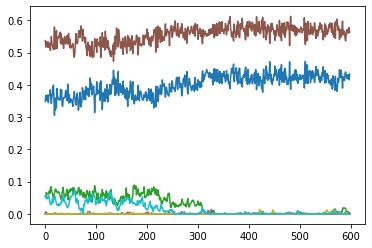

In [ ]:
for i in range(k):
    weights = [w[i] for w in weights_out]
    plt.plot(np.arange(len(weights)) , weights)
    

# Check Metropolis Hastings Traceplots to fullconditional

In [ ]:
#Bijector setup
tfb = tfp.bijectors
bij = tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular()])
mus = np.array([ [0.5,0.5],[-0.5,-0.5] ])
covs = np.array([ np.eye(2) , np.eye(2)] )
cov_prop_mu = 0.05 * np.eye(2)
cov_prop_cov = 0.0001 * np.eye(3)
h = 0
mu_MH = []
cov_MH = []
y = np.array( [datum for datum in data if datum[0] > 0] )
for i in range(1500):
    mus[h],covs[h], acc_rate = sample_uniq_vals_fullcond_Wasserstein_NW_log(y,mus,covs, h,bij,cov_prop_mu,cov_prop_cov)
    print("Acc_rate : " + str(acc_rate))
    mu_MH.append(mus[h].copy())
    cov_MH.append(covs[h].copy())

Acc_rate : 1.1096412256433032e-98
Acc_rate : 2.1235711155151e-272
Acc_rate : 0.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.0
Acc_rate : 1.0
Acc_rate : 3.0512286193438594e-115
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.3866781867763714e-92
Acc_rate : 2.814323503228486e-43
Acc_rate : 2.4523753970208907e-71
Acc_rate : 1.0
Acc_rate : 6.434199009972231e-23
Acc_rate : 3.049349582414915e-73
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 7.551388297591419e-149
Acc_rate : 1.0
Acc_rate : 0.00022173235336493533
Acc_rate : 1.0
Acc_rate : 2.2532095759340354e-208
Acc_rate : 3.0279197408387634e-238
Acc_rate : 1.0
Acc_rate : 8.729195902492805e-07
Acc_rate : 5.859387379453603e-119
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.0
Acc_rate : 1.1488598420399424e-57
Acc_rate : 1.0
Acc_rate : 1.2057386548950963e-51
Acc_rate : 1.0
Acc_rate : 1.2201297547534019e-23
Acc_rate : 1.0
Acc_rate : 8.076214187750088e-307
Acc_rate : 1.0
Acc_rate : 1.751472693321243e-117
Acc_rate : 0.0
Acc_rate : 1.0
Acc_rate : 2.55263970948655

Acc_rate : 4.801349334953023e-10
Acc_rate : 0.00013507447359230424
Acc_rate : 1.0
Acc_rate : 0.037640400847088876
Acc_rate : 1.0
Acc_rate : 7.341614543690808e-05
Acc_rate : 0.7219788951460608
Acc_rate : 6.695427796666732e-10
Acc_rate : 3.9161548427346875e-28
Acc_rate : 3.9527506523628366e-11
Acc_rate : 2.2275487531545073e-06
Acc_rate : 1.3446310770365915e-20
Acc_rate : 5.5539461984740005e-05
Acc_rate : 2.4277094688533725e-14
Acc_rate : 0.04037330432211377
Acc_rate : 2.320510678148926e-27
Acc_rate : 0.0029539941730756447
Acc_rate : 0.0002299635330284277
Acc_rate : 8.050963983988691e-29
Acc_rate : 0.08836184610939087
Acc_rate : 2.846276948102349e-33
Acc_rate : 0.00032382146275433606
Acc_rate : 0.18051143155782515
Acc_rate : 2.5896118660860796e-15
Acc_rate : 0.0011427808842490374
Acc_rate : 2.2211138465441736e-19
Acc_rate : 2.605698142790162e-05
Acc_rate : 1.89928189884293e-05
Acc_rate : 8.892844163164292e-07
Acc_rate : 9.265747002164268e-20
Acc_rate : 1.0
Acc_rate : 9.510515103531293e-09

Acc_rate : 4.1785404133924324e-05
Acc_rate : 0.040591704373237135
Acc_rate : 1.605818225067054e-06
Acc_rate : 1.0
Acc_rate : 9.472859292106434e-24
Acc_rate : 0.3280400065244575
Acc_rate : 0.023684471693378114
Acc_rate : 0.001624781751699212
Acc_rate : 0.0003993176068062564
Acc_rate : 4.507500146131669e-05
Acc_rate : 1.459396656441879e-16
Acc_rate : 7.329570400114136e-11
Acc_rate : 1.8745057616022796e-09
Acc_rate : 1.2358492289979143e-13
Acc_rate : 3.5050035377993644e-06
Acc_rate : 5.58959054018713e-13
Acc_rate : 0.0030182887790793085
Acc_rate : 1.4281579587615344e-09
Acc_rate : 0.002646412078658861
Acc_rate : 4.151808831759468e-12
Acc_rate : 1.0
Acc_rate : 2.3593619620108738e-17
Acc_rate : 0.00037678957211066796
Acc_rate : 0.00010142528943120039
Acc_rate : 2.3205000806908707e-09
Acc_rate : 5.395163818030741e-08
Acc_rate : 4.884399005973567e-16
Acc_rate : 1.339951776542005e-31
Acc_rate : 2.0255557955652677e-05
Acc_rate : 0.000545749450071438
Acc_rate : 0.00015847596368463908
Acc_rate : 

Acc_rate : 1.6593021126292874e-12
Acc_rate : 0.15306330122839135
Acc_rate : 1.0
Acc_rate : 0.913047256535639
Acc_rate : 0.01762657731396764
Acc_rate : 5.317595664851594e-07
Acc_rate : 0.5630355257728087
Acc_rate : 1.126521337250677e-16
Acc_rate : 1.7162983728392966e-06
Acc_rate : 0.013949573924303954
Acc_rate : 0.3957921793479532
Acc_rate : 1.0
Acc_rate : 0.031356355668942515
Acc_rate : 0.09027991715614966
Acc_rate : 2.2195563593355843e-05
Acc_rate : 0.23526896294585922
Acc_rate : 0.00048431219641174
Acc_rate : 0.0003124331191205587
Acc_rate : 3.340463612615044e-18
Acc_rate : 1.2600586234742394e-28
Acc_rate : 1.0980358409449582e-21
Acc_rate : 0.00031823621718484997
Acc_rate : 0.0002747162618364555
Acc_rate : 1.0
Acc_rate : 6.68741530557753e-13
Acc_rate : 3.106400322904899e-13
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 2.91526175413322e-17
Acc_rate : 1.7243315803112443e-06
Acc_rate : 0.029074874734747066
Acc_rate : 1.0
Acc_rate : 4.165103092086034e-11
Acc_rate : 5.685473107177948e-28
Acc_

Acc_rate : 0.025483071436091378
Acc_rate : 9.226065488157389e-07
Acc_rate : 0.7866274132812636
Acc_rate : 3.296206506618444e-08
Acc_rate : 5.292078608429804e-10
Acc_rate : 2.867643488612252e-11
Acc_rate : 0.19649387944721836
Acc_rate : 0.24337092318722756
Acc_rate : 1.7671777247469935e-16
Acc_rate : 5.986008043203783e-19
Acc_rate : 0.0057711630832130364
Acc_rate : 0.00025469668580966736
Acc_rate : 0.5422739715022502
Acc_rate : 2.241325937139598e-05
Acc_rate : 2.8617583681090807e-07
Acc_rate : 1.2981298139526484e-23
Acc_rate : 0.4591830969775925
Acc_rate : 1.0
Acc_rate : 0.0012967857023441919
Acc_rate : 0.0013481939908604938
Acc_rate : 0.18029392870442823
Acc_rate : 9.050143125614202e-11
Acc_rate : 2.4230956657459583e-05
Acc_rate : 0.0087226942028238
Acc_rate : 0.02010690494321126
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.0007164854316994
Acc_rate : 1.125308334751649e-19
Acc_rate : 4.034090811405273e-09
Acc_rate : 0.0020418777687286793
Acc_rate : 0.001099789025554824
Acc_rate : 0.00401

Acc_rate : 0.025861637311025126
Acc_rate : 1.0137333248066554e-07
Acc_rate : 4.831249041068575e-21
Acc_rate : 0.22830794635233265
Acc_rate : 5.547879077878879e-06
Acc_rate : 2.428838663210479e-06
Acc_rate : 0.010413284182582496
Acc_rate : 1.0
Acc_rate : 3.5373088885872877e-16
Acc_rate : 0.006427415337467162
Acc_rate : 4.26229591399691e-15
Acc_rate : 0.04428049153865229
Acc_rate : 1.897786918407177e-12
Acc_rate : 0.021464668373539726
Acc_rate : 0.1341099604452661
Acc_rate : 1.9642530352364247e-06
Acc_rate : 0.00298079948306296
Acc_rate : 0.08044489504066514
Acc_rate : 0.00046182653839445156
Acc_rate : 0.05091711862074519
Acc_rate : 0.08297705150534959
Acc_rate : 0.13712217701555385
Acc_rate : 0.01844262948991641
Acc_rate : 3.510381689205308e-06
Acc_rate : 0.2109688471844711
Acc_rate : 1.7993498022206436e-09
Acc_rate : 0.02343271553758426
Acc_rate : 0.35752510406729476
Acc_rate : 0.47854675342775127
Acc_rate : 6.804466945708326e-10
Acc_rate : 1.3582635149812101e-06
Acc_rate : 6.664726490

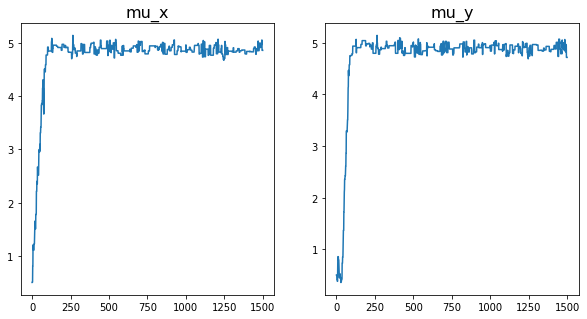

In [ ]:

#Get mean of the first gaussian component
first_comp = [mu[0] for mu in mu_MH]
second_comp = [mu[1] for mu in mu_MH]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("mu_x", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("mu_y", fontsize=16)

plt.show()

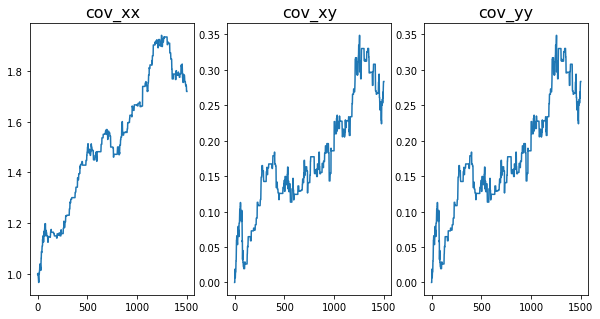

In [ ]:
#Get mean of the first gaussian component
first_comp = [covs[0,0] for covs in cov_MH]
second_comp = [covs[0,1] for covs in cov_MH]
third_comp = [covs[1,1] for covs in cov_MH]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("cov_xx", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("cov_xy", fontsize=16)

axes[2].plot(np.arange(len(third_comp)), second_comp,)
axes[2].set_title("cov_yy", fontsize=16)

plt.show()

# Checking MH convergence to prior

In [ ]:
mus = np.array([ [0.5,0.5],[-0.5,-0.5] ])
covs = np.array([ np.eye(2) , np.eye(2)] )
cov_prop_mu = 0.5 * np.eye(2)
cov_prop_cov = 0.001 * np.eye(3)
h = 0
mu_MH = []
cov_MH = []
y = np.array( [datum for datum in data if datum[0] > 0] )
for i in range(1500):
    mus[h],covs[h], acc_rate = sample_uniq_vals_prior_Wasserstein_NW_log(mus,covs, h,bij,cov_prop_mu,cov_prop_cov)
    print("Acc_rate : " + str(acc_rate))
    mu_MH.append(mus[h].copy())
    cov_MH.append(covs[h].copy())

Acc_rate : 0.7815024444357015
Acc_rate : 0.15057854264559384
Acc_rate : 0.9851691611179811
Acc_rate : 0.2581353792567432
Acc_rate : 1.0
Acc_rate : 0.7255375709599284
Acc_rate : 0.4670645739311092
Acc_rate : 0.009072643216998633
Acc_rate : 0.8657328696685311
Acc_rate : 0.9426202590793011
Acc_rate : 1.0
Acc_rate : 0.760267275215406
Acc_rate : 1.0
Acc_rate : 0.697236514370478
Acc_rate : 0.8491549181118251
Acc_rate : 0.2841701772320325
Acc_rate : 0.3691808173332699
Acc_rate : 0.8828408997058607
Acc_rate : 1.0
Acc_rate : 0.04524803103221843
Acc_rate : 0.3695554438552315
Acc_rate : 0.00735090311368561
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.045724484022964654
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.8180391050352198
Acc_rate : 0.44457100067077576
Acc_rate : 0.7230861258177805
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.907002180318971
Acc_rate : 1.0
Acc_rate : 0.7748385187610767
Acc_rate : 0.7176665797069648
Acc_rate : 1.0
Acc_rate : 1.0
Acc_r

Acc_rate : 1.0
Acc_rate : 0.6292129062938507
Acc_rate : 0.14107216177188556
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.6646495091738627
Acc_rate : 0.9302754081034935
Acc_rate : 0.04554794282687034
Acc_rate : 0.35418673311092647
Acc_rate : 0.24982277862354557
Acc_rate : 1.0
Acc_rate : 0.7664157929195409
Acc_rate : 0.33531678610939886
Acc_rate : 0.39748101178037915
Acc_rate : 0.08584457167223636
Acc_rate : 1.0
Acc_rate : 0.6360930842986314
Acc_rate : 1.0
Acc_rate : 0.7111007342266507
Acc_rate : 1.0
Acc_rate : 0.5006194149998332
Acc_rate : 0.5336008750234307
Acc_rate : 1.0
Acc_rate : 0.24049370922593297
Acc_rate : 0.017098896269309875
Acc_rate : 1.0
Acc_rate : 0.41047997789571605
Acc_rate : 0.16606612549672947
Acc_rate : 0.2811671526125609
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.8424468914691652
Acc_rate : 0.8072043951909218
Acc_rate : 0.17968635695493518
Acc_rate : 0.3446476241278521
Acc_rate : 0.29606803836132267
Acc_rate : 0.4465736808539685
Acc_rate : 1.0
Acc_rate : 

Acc_rate : 0.011839360803252277
Acc_rate : 1.0
Acc_rate : 0.46538920171090276
Acc_rate : 0.20012756302895962
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.7817560955596392
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.7502435142419377
Acc_rate : 1.0
Acc_rate : 0.16694259603226938
Acc_rate : 1.0
Acc_rate : 0.9840557349389242
Acc_rate : 0.35716080297649366
Acc_rate : 0.3405533807839125
Acc_rate : 0.3207142663232787
Acc_rate : 0.027687181719066225
Acc_rate : 0.15208579466633512
Acc_rate : 1.0
Acc_rate : 0.1215283246512186
Acc_rate : 0.3336974607378118
Acc_rate : 0.09971057912882818
Acc_rate : 1.0
Acc_rate : 0.4680916572970408
Acc_rate : 1.0
Acc_rate : 0.6969274912263215
Acc_rate : 0.18909601902933273
Acc_rate : 0.21176884170261792
Acc_rate : 0.4040872059631623
Acc_rate : 0.1827090525472856
Acc_rate : 1.0
Acc_rate : 0.08686412100373475
Acc_rate : 0.08956662559193156
Acc_rate : 0.863670547530442
Acc_rate : 0.011889500226280988
Acc_rate : 1.0
Acc_rate : 0.190890111271

Acc_rate : 0.8408666369570648
Acc_rate : 1.0
Acc_rate : 0.018222105620006368
Acc_rate : 0.7884059173800834
Acc_rate : 0.23499762683177816
Acc_rate : 0.8771583617450417
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.8765957207602249
Acc_rate : 0.4617685551869577
Acc_rate : 0.5788383184772741
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.22981198050548327
Acc_rate : 0.24194104979725067
Acc_rate : 0.46999044407387364
Acc_rate : 0.6415504049653278
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.7733502203050528
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.5586507100213568
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.3082761097703277
Acc_rate : 0.02409975726722621
Acc_rate : 0.1337729996551397
Acc_rate : 0.5261550570911208
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.15500273976780843
Acc_rate : 1.0
Acc_rate : 0.5816772054790751
Acc_rate : 1.0
Ac

Acc_rate : 5.485696620532648e-05
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.041008937940214714
Acc_rate : 0.8631227681145883
Acc_rate : 0.43845333650328266
Acc_rate : 0.05616725328844971
Acc_rate : 0.03799362572506778
Acc_rate : 1.0
Acc_rate : 0.0322176167250557
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.5493851161150133
Acc_rate : 0.17821518936266809
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.8356533143755456
Acc_rate : 1.0
Acc_rate : 0.15617562712755462
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.79185737048198
Acc_rate : 0.18021773448657388
Acc_rate : 0.14249484365191076
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 1.0
Acc_rate : 0.011033488330613381
Acc_rate : 0.2812394008835152
Acc_rate : 0.08118378640023317
Acc_rate : 0.38607299731959327
Acc_rate : 0.02512358065890562
Acc_rate : 0.027226146869774218
Acc_rate : 1.0
Acc_rate : 0.8532461666716661
Acc_rate : 0.1934249209076006
Acc_rate : 1.0
Acc_rate : 0.7857905383

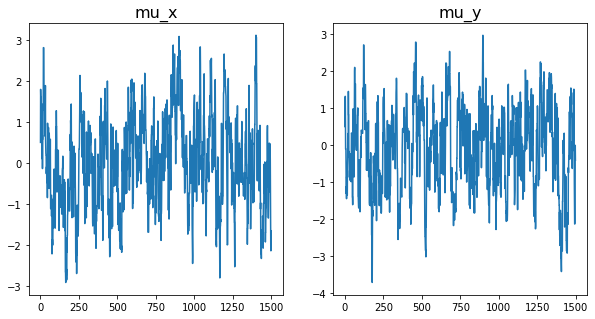

In [ ]:
#Get mean of the first gaussian component
first_comp = [mu[0] for mu in mu_MH]
second_comp = [mu[1] for mu in mu_MH]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("mu_x", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("mu_y", fontsize=16)

plt.show()

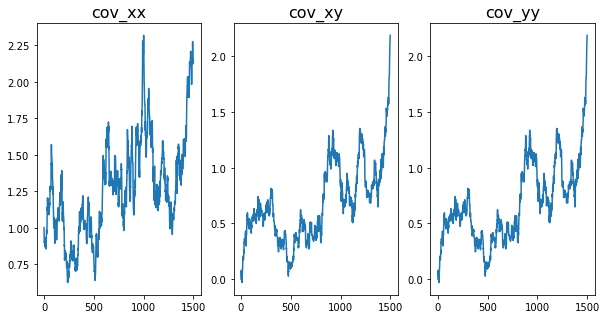

In [ ]:
#Get mean of the first gaussian component
first_comp = [covs[0,0] for covs in cov_MH]
second_comp = [covs[0,1] for covs in cov_MH]
third_comp = [covs[1,1] for covs in cov_MH]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

axes[0].plot(np.arange(len(first_comp)), first_comp)
axes[0].set_title("cov_xx", fontsize=16)

axes[1].plot(np.arange(len(second_comp)), second_comp,)
axes[1].set_title("cov_xy", fontsize=16)

axes[2].plot(np.arange(len(third_comp)), second_comp,)
axes[2].set_title("cov_yy", fontsize=16)

plt.show()